In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Rede Neural - Recorentes
## Ações PETR4

In [40]:
# Importando bade de dados
base = pd.read_csv('../dados/petr4_treinamento.csv')
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [41]:
base.shape

(1245, 7)

In [42]:
# Removendo valores null
base = base.dropna()
base.shape

(1242, 7)

In [43]:
# Pegando valores de abertura
base_treinamento = base.iloc[:, 1:2].values
base_treinamento

array([[19.99    ],
       [19.809999],
       [20.33    ],
       ...,
       [15.99    ],
       [16.1     ],
       [16.1     ]])

In [44]:
# Normalizando dados de treinamento
normalizador = MinMaxScaler(feature_range = (0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_treinamento_normalizada

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [45]:
# Selecionando previsores
previsores = []
preco_real = []

for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i - 90:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])

previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [46]:
# Criando estrutura da rede neural
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))
regressor.add(Dense(units = 1, activation = 'linear'))
# Compilando rede neural
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
# Treinamento do modelo
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
36/36 [==============================] - 12s 145ms/step - loss: 0.0783 - mean_absolute_error: 0.2076
Epoch 2/100
36/36 [==============================] - 5s 141ms/step - loss: 0.0195 - mean_absolute_error: 0.1077
Epoch 3/100
36/36 [==============================] - 5s 150ms/step - loss: 0.0141 - mean_absolute_error: 0.0923
Epoch 4/100
36/36 [==============================] - 5s 150ms/step - loss: 0.0112 - mean_absolute_error: 0.0825
Epoch 5/100
36/36 [==============================] - 5s 150ms/step - loss: 0.0109 - mean_absolute_error: 0.0787
Epoch 6/100
36/36 [==============================] - 5s 150ms/step - loss: 0.0083 - mean_absolute_error: 0.0694
Epoch 7/100
36/36 [==============================] - 6s 158ms/step - loss: 0.0097 - mean_absolute_error: 0.0759
Epoch 8/100
36/36 [==============================] - 5s 146ms/step - loss: 0.0094 - mean_absolute_error: 0.0724
Epoch 9/100
36/36 [==============================] - 5s 139ms/step - loss: 0.0063 - mean_absolute_error

## Realisando Previsões

In [47]:
# Importando bade de dados
base_teste = pd.read_csv('../dados/petr4_teste.csv')
base_teste.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000


In [48]:
base_teste.shape

(22, 7)

In [49]:
# Pegando valores previsores
preco_real_teste = base_teste.iloc[:, 1:2].values
preco_real_teste

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [50]:
# Concatenado bases
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
base_completa.shape

(1264,)

In [51]:
len(base_completa) - len(base_teste) - 90

1152

In [52]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas.shape

(112,)

In [53]:
entradas = entradas.reshape(-1, 1)
entradas.shape

(112, 1)

In [54]:
# Normalizando dados de teste
entradas = normalizador.transform(entradas)

In [55]:
# Selecionando previsores
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i - 90:i, 0])

X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
X_teste.shape

(22, 90, 1)

In [56]:
# Realisando previsão
previsoes = regressor.predict(X_teste)
# Desnormalizando valores de saida
previsoes = normalizador.inverse_transform(previsoes)
previsoes

array([[15.789173],
       [15.838558],
       [16.049456],
       [16.344795],
       [16.403986],
       [16.394522],
       [16.58195 ],
       [16.633125],
       [16.581644],
       [16.652082],
       [16.890991],
       [17.016624],
       [17.384157],
       [17.843672],
       [17.962824],
       [17.900042],
       [17.967678],
       [18.04857 ],
       [18.67526 ],
       [19.137754],
       [19.226885],
       [19.267593]], dtype=float32)

In [57]:
# Médias de previsão e preço real
previsoes.mean(), preco_real_teste.mean()

(17.299608, 17.87454563636364)

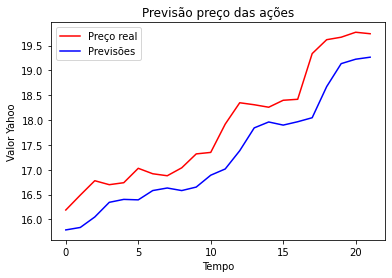

In [58]:
# Plot de previsões e preço real
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()

# Rede Neural - Recorentes
## Múltiplos Previsores

In [13]:
# Importando bade de dados
base = pd.read_csv('../dados/petr4_treinamento.csv')
# Removendo valores null
base = base.dropna()
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [14]:
# Pegando valores previsores
base_treinamento = base.iloc[:, 1:7].values

In [15]:
# Normalizando dados de teste
normalizador = MinMaxScaler(feature_range = (0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [16]:
# Selecionando previsores
previsores = []
preco_real = []

for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i - 90:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

In [17]:
# Criando estrutura da rede neural
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))
regressor.add(Dense(units = 1, activation = 'sigmoid'))
# Compilando rede neural
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

# Definindo funções de callbacks
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', save_best_only = True, verbose = 1)

# Treinamento e teste do modelo
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32, callbacks = [es, rlr, mcp])

Epoch 1/100
36/36 [==============================] - 12s 151ms/step - loss: 0.0239 - mean_absolute_error: 0.1172

Epoch 00001: loss improved from inf to 0.01505, saving model to pesos.h5
Epoch 2/100
36/36 [==============================] - 5s 131ms/step - loss: 0.0059 - mean_absolute_error: 0.0614

Epoch 00002: loss improved from 0.01505 to 0.00535, saving model to pesos.h5
Epoch 3/100
36/36 [==============================] - 5s 131ms/step - loss: 0.0039 - mean_absolute_error: 0.0480

Epoch 00003: loss improved from 0.00535 to 0.00410, saving model to pesos.h5
Epoch 4/100
36/36 [==============================] - 5s 130ms/step - loss: 0.0041 - mean_absolute_error: 0.0502

Epoch 00004: loss improved from 0.00410 to 0.00386, saving model to pesos.h5
Epoch 5/100
36/36 [==============================] - 5s 131ms/step - loss: 0.0036 - mean_absolute_error: 0.0471

Epoch 00005: loss improved from 0.00386 to 0.00348, saving model to pesos.h5
Epoch 6/100
36/36 [==============================] - 

## Realisando Previsões - Múltiplos Previsores

In [18]:
# Importando bade de dados
base_teste = pd.read_csv('../dados/petr4_teste.csv')
# Pegando valores previsores
preco_real_teste = base_teste.iloc[:, 1:2].values
# Concatenando as bases
frames = [base, base_teste]
base_completa = pd.concat(frames)
# Apagando feature Date
base_completa = base_completa.drop('Date', axis = 1)

In [19]:
# Selecionando entradas
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
# Normalizando dados de teste
entradas = normalizador.transform(entradas)

In [20]:
# Selecionando previsores
X_teste = []

for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0:6])

X_teste = np.array(X_teste)

In [21]:
# Realisando previsão
previsoes = regressor.predict(X_teste)
# Desnormalizando valores de saida
normalizador_previsao = MinMaxScaler(feature_range=(0, 1))
normalizador_previsao.fit_transform(base_treinamento[:, 0:1])
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [22]:
# Médias de previsão e preço real
previsoes.mean(), preco_real_teste.mean()

(17.733429, 17.87454563636364)

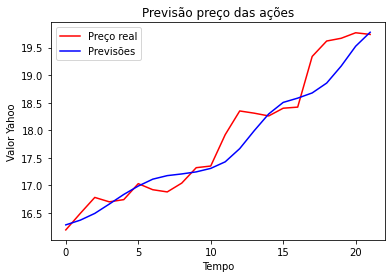

In [23]:
# Plot de previsões e preço real
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()